Refer this article for detailed explanation: https://wandb.ai/authors/embeddings/reports/Word2Vec---VmlldzozMzIxNjQ

In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#lets train on a random set of text. Picked from: https://www.testprepreview.com/modules/reading1.htm

In [2]:
data = '''
Marie Curie was one of the most accomplished scientists in history. Together with her husband, Pierre, she discovered radium, an element widely used for treating cancer, and studied uranium and other radioactive substances. Pierre and Marie’s amicable collaboration later helped to unlock the secrets of the atom.

Marie was born in 1867 in Warsaw, Poland, where her father was a professor of physics. At an early age, she displayed a brilliant mind and a blithe personality. Her great exuberance for learning prompted her to continue with her studies after high school. She became disgruntled, however, when she learned that the university in Warsaw was closed to women. Determined to receive a higher education, she defiantly left Poland and in 1891 entered the Sorbonne, a French university, where she earned her master’s degree and doctorate in physics.

Marie was fortunate to have studied at the Sorbonne with some of the greatest scientists of her day, one of whom was Pierre Curie. Marie and Pierre were married in 1895 and spent many productive years working together in the physics laboratory. A short time after they discovered radium, Pierre was killed by a horse-drawn wagon in 1906. Marie was stunned by this horrible misfortune and endured heartbreaking anguish. Despondently she recalled their close relationship and the joy that they had shared in scientific research. The fact that she had two young daughters to raise by herself greatly increased her distress.

Curie’s feeling of desolation finally began to fade when she was asked to succeed her husband as a physics professor at the Sorbonne. She was the first woman to be given a professorship at the world-famous university. In 1911 she received the Nobel Prize in chemistry for isolating radium. Although Marie Curie eventually suffered a fatal illness from her long exposure to radium, she never became disillusioned about her work. Regardless of the consequences, she had dedicated herself to science and to revealing the mysteries of the physical world.
'''

In [3]:
#convert the data into tokens
tokenized_text = tf.keras.preprocessing.text.text_to_word_sequence(data)
tokenized_text_size = len(tokenized_text)

#create a vocab of unique words
vocab = sorted(set(tokenized_text))
vocab_size = len(vocab)
print(f'vocab size: {vocab_size}')

vocab size: 181


In [4]:
#map the vocab words to individual indices
vocab_to_ix = {c:ix for ix, c in enumerate(vocab)}

#map the indices to the words in vocab
ix_to_vocab = np.array(vocab)

#convert the data into numbers
text_as_int = np.array([vocab_to_ix[c] for c in tokenized_text])

In [36]:
EMBEDDING_SIZE = 10
WINDOW_SIZE = 5
opt = tf.optimizers.Adam()
iterations = 100

## 1. CBOW

In [120]:
#here the word vectors are represented as rows
cbow_context_vector = tf.Variable(np.random.rand(vocab_size, EMBEDDING_SIZE))
cbow_center_vector = tf.Variable(np.random.rand(vocab_size, EMBEDDING_SIZE))

def train_step(indices, loss_list):
    '''
    indices (list): the indices of the vocab in the window
    '''
    with tf.GradientTape() as tape:
        #context
        u_avg = 0
        for count, index in enumerate(indices):
            if count != WINDOW_SIZE // 2:
                u_avg += cbow_context_vector[index, :]
        u_avg /= WINDOW_SIZE - 1
        
        #center
        output = tf.matmul(cbow_center_vector, tf.expand_dims(u_avg, 1))
        
        soft_out = tf.nn.softmax(output, axis=0)
        loss = soft_out[indices[WINDOW_SIZE//2]]
        log_loss = -tf.math.log(loss)
    
    loss_list.append(log_loss.numpy())
    grad = tape.gradient(log_loss, [cbow_context_vector, cbow_center_vector])
    opt.apply_gradients(zip(grad, [cbow_context_vector, cbow_center_vector]))

100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


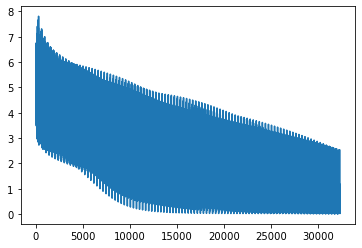

In [121]:
loss_list = []
for iter in tqdm(range(iterations)):
    #creation of window
    for start in range(tokenized_text_size - WINDOW_SIZE):
        indices = text_as_int[start : start + WINDOW_SIZE]
        train_step(indices, loss_list)

plt.plot(loss_list)

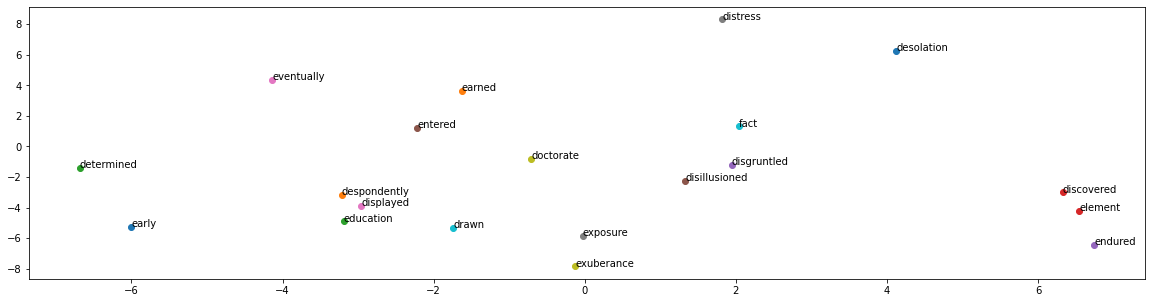

In [127]:
TSNE_embedd = TSNE(n_components=2, random_state=42).fit_transform(cbow_center_vector.numpy())
TSNE_decod = TSNE(n_components=2, random_state=42).fit_transform(cbow_context_vector.numpy())

plt.figure(figsize=(20,5))
for i in range(40,60):
    x, y = TSNE_embedd[i]
    plt.scatter(x,y)
    plt.annotate(ix_to_vocab[i], (x,y))
plt.show()

## 2. Skip Gram

In [128]:
#here the word vectors are represented as rows
sg_context_vector = tf.Variable(np.random.rand(vocab_size, EMBEDDING_SIZE))
sg_center_vector = tf.Variable(np.random.rand(vocab_size, EMBEDDING_SIZE))

In [129]:
def skip_gram_train_step(indices, loss_list):
    with tf.GradientTape() as tape:
        #center
        loss = 0
        v_center = sg_center_vector[indices[WINDOW_SIZE//2], :]
        output = tf.matmul(sg_context_vector, tf.expand_dims(v_center, 1))
        
        soft_out = tf.nn.softmax(output, axis=0)
        
        #context
        for count, index in enumerate(indices):
            if count != WINDOW_SIZE//2:
                loss += soft_out[index]
        
        log_loss = -tf.math.log(loss)
        
    loss_list.append(np.array(log_loss))
    grad = tape.gradient(log_loss, [sg_context_vector, sg_center_vector])
    opt.apply_gradients(zip(grad, [sg_context_vector, sg_center_vector]))

100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


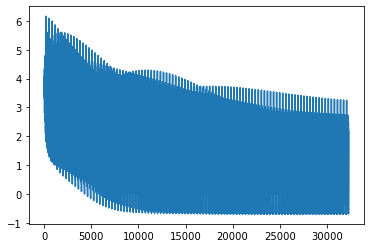

In [130]:
loss_list = []
for iter in tqdm(range(iterations)):
    #creation of window
    for start in range(tokenized_text_size - WINDOW_SIZE):
        indices = text_as_int[start : start + WINDOW_SIZE]
        skip_gram_train_step(indices, loss_list)

plt.plot(loss_list)

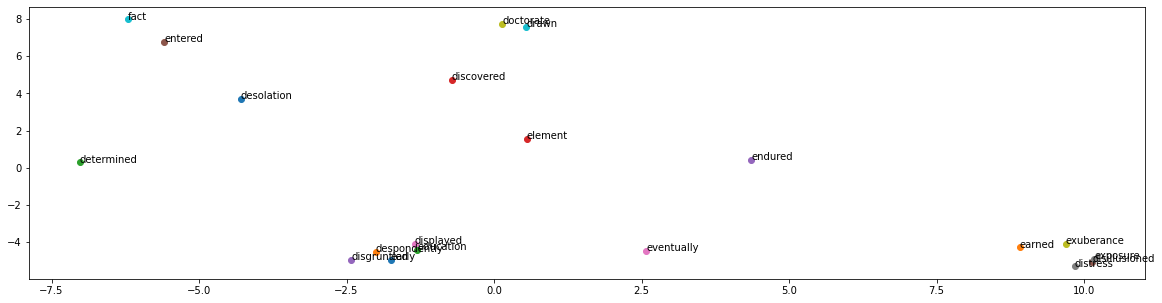

In [132]:
TSNE_embedd = TSNE(n_components=2, random_state=42).fit_transform(sg_center_vector.numpy())
TSNE_decod = TSNE(n_components=2, random_state=42).fit_transform(sg_context_vector.numpy())


plt.figure(figsize=(20,5))
for i in range(40,60):
    x, y = TSNE_embedd[i]
    plt.scatter(x,y)
    plt.annotate(ix_to_vocab[i], (x,y))
plt.show()